In [1]:
import os
import cv2
import numpy as np
import scipy.io as sio
from tqdm import tqdm
from scipy.ndimage import gaussian_filter

# -----------------------------
# Paths
# -----------------------------
images_path = r"C:\Users\sneha\.cache\kagglehub\datasets\tthien\shanghaitech\versions\1\ShanghaiTech\part_A\test_data\images"
gt_path = r"C:\Users\sneha\.cache\kagglehub\datasets\tthien\shanghaitech\versions\1\ShanghaiTech\part_A\test_data\ground-truth"
save_img_path = 'processed_test_A/images/'
save_den_path = 'processed_test_A/density/'

os.makedirs(save_img_path, exist_ok=True)
os.makedirs(save_den_path, exist_ok=True)

# -----------------------------
# Parameters
# -----------------------------
target_size = (512, 512)  # Resize images (H, W)
sigma = 15                # Gaussian sigma for density maps

# -----------------------------
# Helper: Load ShanghaiTech GT points
# -----------------------------
def load_shanghai_gt(gt_file):
    mat = sio.loadmat(gt_file)
    points = np.zeros((0,2), dtype=np.float32)
    
    if 'image_info' in mat:  # Format for part_B
        try:
            pts = mat['image_info'][0,0][0,0]['location']
            if pts.size > 0:
                points = np.array(pts, dtype=np.float32)
        except Exception:
            points = np.zeros((0,2), dtype=np.float32)
    elif 'GT' in mat:
        pts = mat['GT']
        if pts.size > 0:
            points = np.array(pts, dtype=np.float32)
    
    # Ensure shape is (N,2)
    if points.ndim == 1:
        points = points.reshape(-1,2)
    return points

# -----------------------------
# Helper: Create density map
# -----------------------------
def create_density_map(points, img_shape, sigma=15):
    h, w = img_shape
    density = np.zeros((h,w), dtype=np.float32)
    if points is None or len(points) == 0:
        return density
    for point in points:
        x = min(w-1, max(0, int(point[0])))
        y = min(h-1, max(0, int(point[1])))
        density[y, x] = 1
    density = gaussian_filter(density, sigma=sigma)
    return density

# -----------------------------
# Main preprocessing loop
# -----------------------------
image_files = [f for f in os.listdir(images_path) if f.endswith('.jpg') or f.endswith('.png')]
print(f"Found {len(image_files)} images.")

for img_file in tqdm(image_files):
    # Load original image
    img_orig = cv2.imread(os.path.join(images_path, img_file))
    orig_h, orig_w = img_orig.shape[:2]

    # Convert BGR -> RGB and resize
    img = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img_norm = img / 255.0

    # Save processed image
    save_img_name = os.path.join(save_img_path, img_file.split('.')[0]+'.npy')
    np.save(save_img_name, img_norm.astype(np.float32))

    # Load GT points
   # Load GT points
    gt_file_name = 'GT_' + img_file.split('.')[0] + '.mat'
    gt_file = os.path.join(gt_path, gt_file_name)
    points = load_shanghai_gt(gt_file)


    # Scale points to resized image
    if points.size > 0:
        points[:,0] = points[:,0] * (target_size[1] / orig_w)
        points[:,1] = points[:,1] * (target_size[0] / orig_h)

    # Create density map
    density_map = create_density_map(points, target_size, sigma=sigma)

    # Normalize density map to match total count
    if points.size > 0 and density_map.sum() > 0:
        density_map = density_map / density_map.sum() * len(points)

    # Save density map
    save_den_name = os.path.join(save_den_path, img_file.split('.')[0]+'.npy')
    np.save(save_den_name, density_map.astype(np.float32))

    # Debug print for first few images
    if '0' in img_file:
        print(img_file, "people count:", len(points), "density sum:", density_map.sum())

print("✅ Preprocessing complete! Check 'processed_new/images/' and 'processed_new/density/' folders.")


Found 182 images.


  2%|▏         | 3/182 [00:00<00:14, 12.68it/s]

IMG_10.jpg people count: 502 density sum: 502.00003
IMG_100.jpg people count: 389 density sum: 389.00003
IMG_101.jpg people count: 211 density sum: 211.0
IMG_102.jpg people count: 223 density sum: 223.0


  4%|▍         | 7/182 [00:00<00:18,  9.65it/s]

IMG_103.jpg people count: 431 density sum: 430.9999
IMG_104.jpg people count: 1175 density sum: 1175.0


  5%|▍         | 9/182 [00:00<00:16, 10.24it/s]

IMG_105.jpg people count: 265 density sum: 265.0
IMG_106.jpg people count: 1232 density sum: 1232.0
IMG_107.jpg people count: 289 density sum: 289.0


  6%|▌         | 11/182 [00:01<00:18,  9.45it/s]

IMG_108.jpg people count: 182 density sum: 182.00003
IMG_109.jpg people count: 379 density sum: 379.0


  8%|▊         | 15/182 [00:01<00:17,  9.32it/s]

IMG_110.jpg people count: 1021 density sum: 1021.00006


 15%|█▍        | 27/182 [00:02<00:12, 12.34it/s]

IMG_120.jpg people count: 133 density sum: 133.00002


 20%|██        | 37/182 [00:03<00:11, 12.46it/s]

IMG_130.jpg people count: 921 density sum: 921.0


 26%|██▋       | 48/182 [00:04<00:14,  9.46it/s]

IMG_140.jpg people count: 93 density sum: 92.99999


 32%|███▏      | 59/182 [00:05<00:10, 12.08it/s]

IMG_150.jpg people count: 1303 density sum: 1303.0


 38%|███▊      | 69/182 [00:06<00:09, 11.52it/s]

IMG_160.jpg people count: 121 density sum: 120.99999


 44%|████▍     | 80/182 [00:07<00:11,  8.83it/s]

IMG_170.jpg people count: 670 density sum: 669.9999


 51%|█████     | 92/182 [00:09<00:13,  6.77it/s]

IMG_180.jpg people count: 398 density sum: 398.0


 53%|█████▎    | 97/182 [00:10<00:12,  6.86it/s]

IMG_20.jpg people count: 460 density sum: 460.0


 60%|█████▉    | 109/182 [00:11<00:07,  9.75it/s]

IMG_30.jpg people count: 307 density sum: 307.0


 65%|██████▌   | 119/182 [00:12<00:06,  9.69it/s]

IMG_40.jpg people count: 236 density sum: 236.0


 72%|███████▏  | 131/182 [00:14<00:06,  7.88it/s]

IMG_50.jpg people count: 997 density sum: 997.0


 77%|███████▋  | 140/182 [00:15<00:04, 10.11it/s]

IMG_60.jpg people count: 291 density sum: 291.0


 84%|████████▎ | 152/182 [00:16<00:03,  9.57it/s]

IMG_70.jpg people count: 412 density sum: 412.00003


 89%|████████▉ | 162/182 [00:17<00:02,  9.94it/s]

IMG_80.jpg people count: 157 density sum: 157.00002


 96%|█████████▌| 174/182 [00:19<00:01,  6.79it/s]

IMG_90.jpg people count: 2256 density sum: 2256.0


100%|██████████| 182/182 [00:20<00:00,  8.85it/s]

✅ Preprocessing complete! Check 'processed_new/images/' and 'processed_new/density/' folders.


Total people: 232.99998


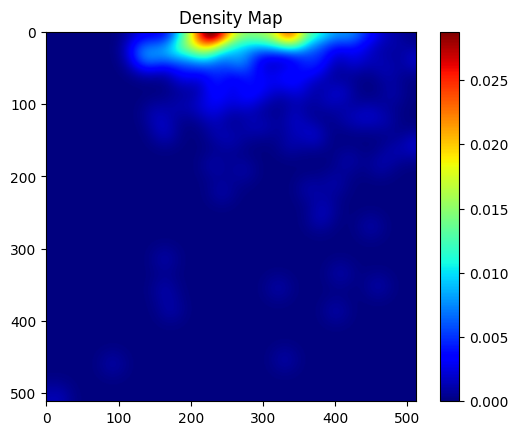

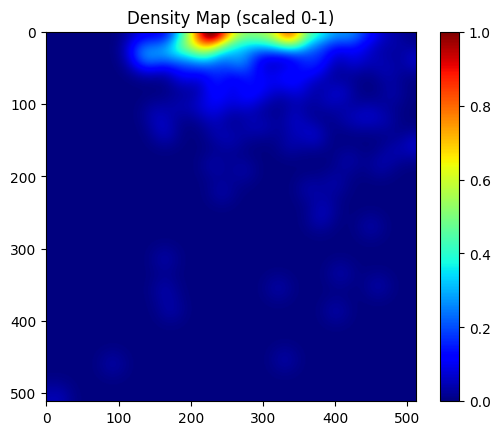

In [19]:
import numpy as np
import matplotlib.pyplot as plt

density = np.load('processed_new/density/IMG_1.npy')  # your file
print("Total people:", density.sum())

plt.imshow(density, cmap='jet')           # normal visualization
plt.colorbar()
plt.title("Density Map")
plt.show()

# Optional: scale for visibility only
plt.imshow(density / density.max(), cmap='jet')
plt.colorbar()
plt.title("Density Map (scaled 0-1)")
plt.show()


In [4]:
import os

print("Density folder exists?", os.path.exists(den_path))
print("Files in density folder:", os.listdir(den_path))


Density folder exists? True
Files in density folder: []


In [5]:
den_files = sorted([f for f in os.listdir(den_path) if f.endswith('.npy')])  # for .npy
# OR
den_files = sorted([f for f in os.listdir(den_path) if f.endswith('.jpg')])  # for .jpg


In [20]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

# -----------------------------
# Paths
# -----------------------------
img_path = 'processed_new/images/'
den_path = 'processed_new/density/'
save_model_path = 'models/'
os.makedirs(save_model_path, exist_ok=True)

# -----------------------------
# Hyperparameters
# -----------------------------
batch_size = 4
learning_rate = 1e-5
num_epochs = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# -----------------------------
# Custom Dataset
# -----------------------------
class CrowdDataset(Dataset):
    def __init__(self, img_dir, den_dir):
        self.img_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.npy')])
        self.den_files = sorted([f for f in os.listdir(den_dir) if f.endswith('.npy')])
        self.img_dir = img_dir
        self.den_dir = den_dir

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img = np.load(os.path.join(self.img_dir, self.img_files[idx]))
        den = np.load(os.path.join(self.den_dir, self.den_files[idx]))

        # Convert to torch tensors
        img = torch.tensor(img.transpose((2,0,1)), dtype=torch.float32)  # C,H,W
        den = torch.tensor(den[np.newaxis, :, :], dtype=torch.float32)   # 1,H,W

        return img, den

# -----------------------------
# Load dataset
# -----------------------------
dataset = CrowdDataset(img_path, den_path)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

# -----------------------------
# CSRNet model (VGG frontend + conv backend)
# -----------------------------
class CSRNet(nn.Module):
    def __init__(self, load_weights=True):
        super(CSRNet, self).__init__()
        # Frontend: VGG-16 features
        vgg = nn.Sequential(
            nn.Conv2d(3,64,3,padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64,64,3,padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64,128,3,padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(128,128,3,padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            nn.Conv2d(128,256,3,padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256,256,3,padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256,256,3,padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            nn.Conv2d(256,512,3,padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(512,512,3,padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(512,512,3,padding=1), nn.ReLU(inplace=True)
        )
        self.frontend = vgg

        # Backend: dilated convolutions
        self.backend = nn.Sequential(
            nn.Conv2d(512,512,3,padding=2,dilation=2), nn.ReLU(inplace=True),
            nn.Conv2d(512,512,3,padding=2,dilation=2), nn.ReLU(inplace=True),
            nn.Conv2d(512,512,3,padding=2,dilation=2), nn.ReLU(inplace=True),
            nn.Conv2d(512,256,3,padding=2,dilation=2), nn.ReLU(inplace=True),
            nn.Conv2d(256,128,3,padding=2,dilation=2), nn.ReLU(inplace=True),
            nn.Conv2d(128,64,3,padding=2,dilation=2), nn.ReLU(inplace=True),
            nn.Conv2d(64,1,1)
        )

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        return x

# -----------------------------
# Initialize model, loss, optimizer
# -----------------------------
model = CSRNet().to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# -----------------------------
# Training loop
# -----------------------------
loss_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for imgs, dens in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        imgs, dens = imgs.to(device), dens.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)

        # If output and GT shapes mismatch, interpolate
        if outputs.shape != dens.shape:
            outputs = nn.functional.interpolate(outputs, size=dens.shape[2:], mode='bilinear', align_corners=False)

        loss = criterion(outputs, dens)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

    epoch_loss = running_loss / len(dataset)
    loss_history.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {epoch_loss:.6f}")

    # Save checkpoint
    torch.save({
        'epoch': epoch+1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss_history': loss_history
    }, os.path.join(save_model_path, f'csrnet_epoch_{epoch+1}.pth'))

# -----------------------------
# Plot loss curve
# -----------------------------
plt.figure()
plt.plot(range(1,num_epochs+1), loss_history, marker='o')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.show()

print("✅ Training complete. All checkpoints saved in", save_model_path)


Using device: cpu


Epoch 1/5: 100%|██████████| 100/100 [58:52<00:00, 35.32s/it]


Epoch [1/5] Loss: 0.001439


Epoch 2/5: 100%|██████████| 100/100 [1:09:27<00:00, 41.67s/it]


Epoch [2/5] Loss: 0.000019


Epoch 3/5: 100%|██████████| 100/100 [45:45<00:00, 27.45s/it] 


Epoch [3/5] Loss: 0.000007


Epoch 4/5:   0%|          | 0/100 [00:03<?, ?it/s]


KeyboardInterrupt: 

In [30]:
checkpoint = torch.load("models/csrnet_epoch_3.pth", map_location=device)
print(checkpoint.keys())


dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'loss_history'])


Model loaded from epoch: 3
Predicted Count: -22.29


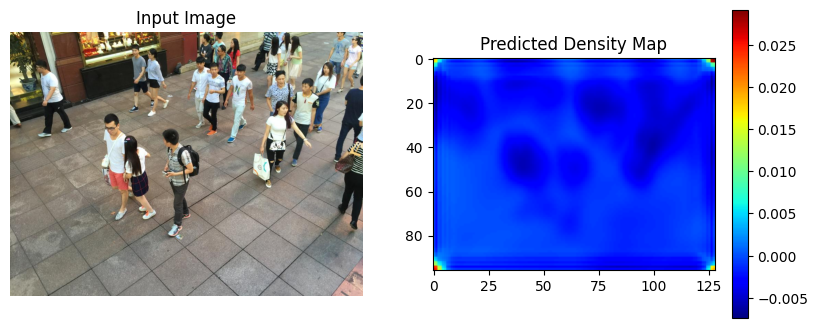

np.float32(-22.291714)

In [33]:
import torch
import cv2
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms

# -------------------- Load Model --------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CSRNet().to(device)
checkpoint = torch.load("models/csrnet_epoch_3.pth", map_location=device)

model.load_state_dict(checkpoint["model_state_dict"])
model.eval()
print("Model loaded from epoch:", checkpoint["epoch"])

# -------------------- Preprocessing --------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# -------------------- Test on a single image --------------------
def predict_count(img_path):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img_rgb.shape

    # Preprocess
    img_tensor = transform(img_rgb).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_tensor)

    # Resize to match ground truth if needed
    output_resized = torch.nn.functional.interpolate(
        output, size=(h//8, w//8), mode='bilinear', align_corners=False
    )

    density_map = output_resized.cpu().numpy()[0,0]
    predicted_count = density_map.sum()

    print(f"Predicted Count: {predicted_count:.2f}")

    # Show map
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.imshow(img_rgb)
    plt.title("Input Image")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(density_map, cmap='jet')
    plt.title("Predicted Density Map")
    plt.colorbar()

    plt.show()

    return predicted_count

# -------------------- Test --------------------
predict_count(r"C:\Users\sneha\.cache\kagglehub\datasets\tthien\shanghaitech\versions\1\ShanghaiTech\part_B\test_data\images\IMG_1.jpg")


In [34]:
resume_from = "models/csrnet_epoch_3.pth"   # set to None to start fresh
start_epoch = 1

if resume_from is not None:
    checkpoint = torch.load(resume_from, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    start_epoch = checkpoint["epoch"] + 1
    print(f"Resuming training from epoch {start_epoch}")
else:
    print("Starting training from scratch")


Resuming training from epoch 4


In [35]:
for epoch in range(start_epoch, num_epochs + 20):
    model.train()
    running_loss = 0.0
    for imgs, dens in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        imgs, dens = imgs.to(device), dens.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)

        # If output and GT shapes mismatch, interpolate
        if outputs.shape != dens.shape:
            outputs = nn.functional.interpolate(outputs, size=dens.shape[2:], mode='bilinear', align_corners=False)

        loss = criterion(outputs, dens)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

    epoch_loss = running_loss / len(dataset)
    loss_history.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {epoch_loss:.6f}")

    # Save checkpoint
    torch.save({
        'epoch': epoch+1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss_history': loss_history
    }, os.path.join(save_model_path, f'csrnet_epoch_{epoch+1}.pth'))

# -----------------------------
# Plot loss curve
# -----------------------------
plt.figure()
plt.plot(range(1,num_epochs+1), loss_history, marker='o')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.show()

print("✅ Training complete. All checkpoints saved in", save_model_path)
    


Epoch 5/5: 100%|██████████| 100/100 [1:05:27<00:00, 39.28s/it]


Epoch [5/5] Loss: 0.000006


Epoch 6/5: 100%|██████████| 100/100 [5:59:42<00:00, 215.82s/it]   


Epoch [6/5] Loss: 0.000006


Epoch 7/5: 100%|██████████| 100/100 [36:45<00:00, 22.05s/it]


Epoch [7/5] Loss: 0.000006


Epoch 8/5: 100%|██████████| 100/100 [42:21<00:00, 25.41s/it]


Epoch [8/5] Loss: 0.000006


Epoch 9/5: 100%|██████████| 100/100 [1:13:16<00:00, 43.97s/it]


Epoch [9/5] Loss: 0.000006


Epoch 10/5: 100%|██████████| 100/100 [43:36<00:00, 26.16s/it] 


Epoch [10/5] Loss: 0.000006


Epoch 11/5: 100%|██████████| 100/100 [1:14:38<00:00, 44.79s/it]


Epoch [11/5] Loss: 0.000006


Epoch 12/5:   0%|          | 0/100 [00:06<?, ?it/s]


KeyboardInterrupt: 

In [2]:
import os
import cv2
import torch
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader


In [3]:
class CrowdDataset(Dataset):
    def __init__(self, img_paths, dens_paths, img_size=(512, 512)):
        self.img_paths = img_paths
        self.dens_paths = dens_paths
        self.img_size = img_size
        self.transform = transforms.ToTensor()

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):

        # ---- IMAGE ----
        img = Image.open(self.img_paths[idx]).convert("RGB")
        img = img.resize(self.img_size)  
        img = self.transform(img)        # now a tensor

        # ---- DENSITY MAP ----
        dens = np.load(self.dens_paths[idx]).astype(np.float32)
        h0, w0 = dens.shape  # original size

        # resize density
        dens = cv2.resize(dens, self.img_size)

        # scale density values to preserve count
        h1, w1 = dens.shape
        dens = dens * ((h0 * w0) / (h1 * w1))

        dens = torch.tensor(dens).unsqueeze(0)

        return img, dens


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
import os
import numpy as np
class CSRNet(nn.Module):
    def __init__(self):
        super(CSRNet, self).__init__()

        self.frontend = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 512, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True)
        )

        self.backend = nn.Sequential(
            nn.Conv2d(512, 512, 3, dilation=2, padding=2), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, dilation=2, padding=2), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, dilation=2, padding=2), nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, 3, dilation=2, padding=2), nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, 3, dilation=2, padding=2), nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, 3, dilation=2, padding=2), nn.ReLU(inplace=True),
        )

        self.output_layer = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x


In [23]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
from PIL import Image
from tqdm import tqdm
from math import sqrt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# =========================================================
# 1. TEST DATASET CLASS
# =========================================================
class TestDataset(Dataset):
    def __init__(self, img_dir, den_dir, transform=None):
        self.img_dir = img_dir
        self.den_dir = den_dir
        self.transform = transform

        self.img_files = sorted([f for f in os.listdir(img_dir) if f.endswith(".jpg") or f.endswith(".png")])
        self.den_files = sorted([f for f in os.listdir(den_dir) if f.endswith(".npy")])

        assert len(self.img_files) == len(self.den_files), "❌ Images and density maps count mismatch"

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        den_path = os.path.join(self.den_dir, self.den_files[idx])

        # Load image
        img = Image.open(img_path).convert("RGB")
        img = np.array(img, dtype=np.float32) / 255.0
        img = torch.tensor(img).permute(2, 0, 1)  # HWC → CHW

        # Load density map
        den = np.load(den_path)  # (H, W)
        den = torch.tensor(den, dtype=torch.float32).unsqueeze(0)

        return img, den


# =========================================================
# 2. SET YOUR PATHS HERE
# =========================================================
import os

test_img_dir = "processed_B/images"
test_den_dir = "processed_B/density"
# test_img_dir = r"C:\Users\sneha\.cache\kagglehub\datasets\tthien\shanghaitech\versions\1\ShanghaiTech\part_A\train_data\images"
# test_den_dir = r"C:\Users\sneha\.cache\kagglehub\datasets\tthien\shanghaitech\versions\1\ShanghaiTech\part_A\train_data\ground-truth"


test_dataset = TestDataset(test_img_dir, test_den_dir)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

print(f"Loaded {len(test_dataset)} test images ✔")


# =========================================================
# 3. LOAD MODEL & CHECKPOINT
# =========================================================
model = CSRNet().to(device)

checkpoint_path = "sneha/csrnet_checkpoint.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)

model.load_state_dict(checkpoint["model"])
model.eval()

print("✅ Model loaded successfully!")


# =========================================================
# 4. POST PROCESSING
# =========================================================
def smooth(pred):
    x = pred[0, 0].cpu().numpy()
    return cv2.GaussianBlur(x, (5, 5), 0)


def clip(pred):
    cap = np.percentile(pred, 99)
    return np.clip(pred, 0, cap)


def correction(count):
    return count * 0.92


# =========================================================
# 5. EVALUATION LOOP
# =========================================================
mae = 0
mse = 0

print("\nStarting evaluation...")

for img, gt_den in tqdm(test_loader):
    img = img.to(device)
    gt_den = gt_den.to(device)

    with torch.no_grad():
        pred = model(img)
        pred = F.interpolate(pred, size=gt_den.shape[2:], mode='bilinear', align_corners=False)

    raw = pred.sum().item()

    # Post-processing
    sm = smooth(pred)
    cp = clip(sm)
    final_count = correction(cp.sum())

    gt = gt_den.sum().item()

    mae += abs(final_count - gt)
    mse += (final_count - gt) ** 2


MAE = mae / len(test_loader)
MSE = mse / len(test_loader)
RMSE = sqrt(MSE)

print("\n==============================")
print("📊 FINAL TEST RESULTS")
print("==============================")
print(f"⭕ MAE  = {MAE:.2f}")
print(f"📘 MSE  = {MSE:.2f}")
print(f"📏 RMSE = {RMSE:.2f}")
print("==============================")


Loaded 400 test images ✔
✅ Model loaded successfully!

Starting evaluation...


100%|██████████| 400/400 [1:11:42<00:00, 10.76s/it]


📊 FINAL TEST RESULTS
⭕ MAE  = 49.39
📘 MSE  = 4093.74
📏 RMSE = 63.98


In [6]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
from PIL import Image
from tqdm import tqdm
from math import sqrt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# =========================================================
# 1. TEST DATASET CLASS
# =========================================================
class TestDataset(Dataset):
    def __init__(self, img_dir, den_dir, transform=None):
        self.img_dir = img_dir
        self.den_dir = den_dir
        self.transform = transform

        self.img_files = sorted([f for f in os.listdir(img_dir) if f.endswith(".jpg") or f.endswith(".png")])
        self.den_files = sorted([f for f in os.listdir(den_dir) if f.endswith(".npy")])

        assert len(self.img_files) == len(self.den_files), "❌ Images and density maps count mismatch"

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        den_path = os.path.join(self.den_dir, self.den_files[idx])

        # Load image
        img = Image.open(img_path).convert("RGB")
        img = np.array(img, dtype=np.float32) / 255.0
        img = torch.tensor(img).permute(2, 0, 1)  # HWC → CHW

        # Load density map
        den = np.load(den_path)  # (H, W)
        den = torch.tensor(den, dtype=torch.float32).unsqueeze(0)

        return img, den


# =========================================================
# 2. SET YOUR PATHS HERE
# =========================================================
import os

test_img_dir = "processed/images"
test_den_dir = "processed/density"
# test_img_dir = r"C:\Users\sneha\.cache\kagglehub\datasets\tthien\shanghaitech\versions\1\ShanghaiTech\part_A\train_data\images"
# test_den_dir = r"C:\Users\sneha\.cache\kagglehub\datasets\tthien\shanghaitech\versions\1\ShanghaiTech\part_A\train_data\ground-truth"


test_dataset = TestDataset(test_img_dir, test_den_dir)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

print(f"Loaded {len(test_dataset)} test images ✔")


# =========================================================
# 3. LOAD MODEL & CHECKPOINT
# =========================================================
model = CSRNet().to(device)

checkpoint_path = "sneha/csrnet_checkpoint.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)

model.load_state_dict(checkpoint["model"])
model.eval()

print("✅ Model loaded successfully!")


# =========================================================
# 4. POST PROCESSING
# =========================================================
def smooth(pred):
    x = pred[0, 0].cpu().numpy()
    return cv2.GaussianBlur(x, (5, 5), 0)


def clip(pred):
    cap = np.percentile(pred, 99)
    return np.clip(pred, 0, cap)


def correction(count):
    return count * 0.92


# =========================================================
# 5. EVALUATION LOOP
# =========================================================
mae = 0
mse = 0

print("\nStarting evaluation...")

for img, gt_den in tqdm(test_loader):
    img = img.to(device)
    gt_den = gt_den.to(device)

    with torch.no_grad():
        pred = model(img)
        pred = F.interpolate(pred, size=gt_den.shape[2:], mode='bilinear', align_corners=False)

    raw = pred.sum().item()

    # Post-processing
    sm = smooth(pred)
    cp = clip(sm)
    final_count = correction(cp.sum())

    gt = gt_den.sum().item()

    mae += abs(final_count - gt)
    mse += (final_count - gt) ** 2


MAE = mae / len(test_loader)
MSE = mse / len(test_loader)
RMSE = sqrt(MSE)

print("\n==============================")
print("📊 FINAL TEST RESULTS")
print("==============================")
print(f"⭕ MAE  = {MAE:.2f}")
print(f"📘 MSE  = {MSE:.2f}")
print(f"📏 RMSE = {RMSE:.2f}")
print("==============================")


Loaded 300 test images ✔
✅ Model loaded successfully!

Starting evaluation...


100%|██████████| 300/300 [20:28<00:00,  4.09s/it]


📊 FINAL TEST RESULTS
⭕ MAE  = 317.59
📘 MSE  = 265898.28
📏 RMSE = 515.65


In [18]:
checkpoint_path = "csrnet_checkpoint.pth"

checkpoint = torch.load(checkpoint_path, map_location="cpu")
model.load_state_dict(checkpoint["model"])

print("Loaded checkpoint from epoch:", checkpoint["epoch"])


Loaded checkpoint from epoch: 50


In [19]:
def smooth_map(dm):
    dm = cv2.GaussianBlur(dm, (7, 7), 1)
    dm = cv2.GaussianBlur(dm, (17, 17), 2)
    return dm

def threshold_map(dm, thr=0.05):
    dm = dm - dm.min()
    dm = dm / (dm.max() + 1e-6)
    dm[dm < thr] = 0
    return dm


In [20]:
mae = 0
mse = 0

save_results = "eval_vis"
os.makedirs(save_results, exist_ok=True)

model.eval()
model.to("cpu")

with torch.no_grad():
    for idx, (img, gt) in enumerate(tqdm(test_loader)):

        img = img.to("cpu")
        gt = gt.to("cpu")

        pred = model(img)

        # Resize prediction to match GT size
        if pred.shape != gt.shape:
            pred = torch.nn.functional.interpolate(pred, size=gt.shape[2:], mode='bilinear', align_corners=False)

        pred_np = pred.squeeze().cpu().numpy()
        gt_np = gt.squeeze().cpu().numpy()

        # Apply post-processing
        pred_np = smooth_map(pred_np)
        pred_np = threshold_map(pred_np)

        pred_count = pred_np.sum()
        gt_count = gt_np.sum()

        diff = abs(pred_count - gt_count)

        mae += diff
        mse += diff ** 2

        # Save visualization
        plt.figure(figsize=(10,4))

        plt.subplot(1,2,1)
        plt.title(f"GT Count = {gt_count:.1f}")
        plt.imshow(gt_np, cmap='jet')
        plt.colorbar()

        plt.subplot(1,2,2)
        plt.title(f"Pred Count = {pred_count:.1f}")
        plt.imshow(pred_np, cmap='jet')
        plt.colorbar()

        plt.savefig(f"{save_results}/{idx:04d}.png")
        plt.close()

# Final Results
n = len(test_loader)
mae /= n
mse /= n
rmse = np.sqrt(mse)

print("\n====================")
print("📊 FINAL TEST METRICS")
print("====================")
print(f"⭕ MAE  = {mae:.2f}")
print(f"📘 MSE  = {mse:.2f}")
print(f"📏 RMSE = {rmse:.2f}")
print("====================")


100%|██████████| 300/300 [17:41<00:00,  3.54s/it]


📊 FINAL TEST METRICS
⭕ MAE  = 62098.77
📘 MSE  = 4788553216.00
📏 RMSE = 69199.38
